### Import everthing

In [1]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache/'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


In [2]:
from allensdk.brain_observatory.natural_scenes import NaturalScenes
from allensdk.brain_observatory.static_gratings import StaticGratings
from allensdk.brain_observatory.natural_movie import NaturalMovie
from scipy.stats import binned_statistic
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding, MDS
from sklearn.covariance import EmpiricalCovariance
from scipy.spatial.distance import squareform, pdist

scriptpath = '/home/arib/SWDB_2017/swdb_2017_tools'
sys.path.append(scriptpath)

from swdb2017.brain_observatory.RSA_with_options import *

#from swdb2017.brain_observatory.get_rsm import *

### Get all experiement ids

In [3]:
# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print 'all targeted structures: ' + str(targeted_structures)

# Download a list of all imaging depths
depths = boc.get_all_imaging_depths()
print 'all imaging depths: ' + str(depths)

# Download a list of all cre driver lines 
cre_lines = boc.get_all_cre_lines()
print 'all cre lines: ' + str(cre_lines)

all targeted structures: [u'VISal', u'VISam', u'VISl', u'VISp', u'VISpm', u'VISrl']
all imaging depths: [175, 265, 275, 300, 320, 325, 335, 350, 365, 375, 435]
all cre lines: [u'Cux2-CreERT2', u'Emx1-IRES-Cre', u'Nr5a1-Cre', u'Rbp4-Cre_KL100', u'Rorb-IRES2-Cre', u'Scnn1a-Tg3-Cre']


In [4]:
all_exps_df = pd.DataFrame(boc.get_experiment_containers(targeted_structures= targeted_structures,
                                                     cre_lines= cre_lines, imaging_depths = depths))

rsa_types = ['rsa_mean_mean_mahala','rsa_random_mean_mahala', 'rsa_mean_mean_spectral_embedding', 'rsa_mean_mean_PCA','valid_stim']
for rsa_ in rsa_types:
    all_exps_df[rsa_] = 0
    all_exps_df[rsa_] = all_exps_df[rsa_].astype(object)


all_exps_df.head()

,cre_line,donor_name,failed,id,imaging_depth,reporter_line,specimen_name,tags,targeted_structure,rsa_mean_mean_mahala,rsa_random_mean_mahala,rsa_mean_mean_spectral_embedding,rsa_mean_mean_PCA,valid_stim
0,Cux2-CreERT2,283284,False,566759225,275,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-283284,[],VISam,0,0,0,0,0
1,Nr5a1-Cre,261969,False,546328009,350,Ai93(TITL-GCaMP6f),Nr5a1-Cre;Camk2a-tTA;Ai93-261969,[],VISal,0,0,0,0,0
2,Scnn1a-Tg3-Cre,230570,False,511510911,350,Ai93(TITL-GCaMP6f),Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-230570,[],VISp,0,0,0,0,0
3,Emx1-IRES-Cre,284669,False,569792815,375,Ai93(TITL-GCaMP6f),Emx1-IRES-Cre;Camk2a-tTA;Ai93-284669,[],VISam,0,0,0,0,0
4,Rbp4-Cre_KL100,234584,False,511511015,375,Ai93(TITL-GCaMP6f),Rbp4-Cre;Camk2a-tTA;Ai93-234584,[],VISpm,0,0,0,0,0


In [5]:
exp_id = all_exps_df.loc[0,'id']

##### Run for all natural scene sessions

### Full pipeline

In [6]:
def get_all_data(exp_id, only_responsive = True, running_thresh=3, stimuli = ['natural_scenes', 'static_gratings', 'natural_movie_one']):
    """Gets all the data. We'll only use session B.
    
    Returns a matrix of trials x n_neurons, and another of frames x neurons.
    
    Eye position
    
    Parameters
    ----------
    running_thresh: threshold above which to discard cells. If None, does not sort by running 
    """
    dfs = []

    for stim in stimuli:
        session = boc.get_ophys_experiments(experiment_container_ids=[exp_id], stimuli=[stim])
        
        session_id =[session[i]['id'] for i in range(len(session)) 
                         if session[i]['session_type']=='three_session_B'][0]
        if session_id==[]: 
            # This stimulus does not exist.
            print('No '+stim+' for this experiment: ' + str(exp_id))
            continue
            
        data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)
        analysis_path = os.path.join(drive_path, 'ophys_experiment_analysis')
        analysis_file = os.path.join(analysis_path, str(session_id) + '_three_session_B_analysis.h5')
        
        if stim == 'natural_scenes':  
            ns = NaturalScenes.from_analysis_file(data_set, analysis_file)
            df = ns.mean_sweep_response
            
#             avg_locs, std_locs = get_mean_pupil(data_set, stim)
#             df['mean_pupil_loc_x'] = avg_locs[:,0]
#             df['mean_pupil_loc_y'] = avg_locs[:,1]
#             df['pupil_loc_std_x'] = std_locs[:,0]
#             df['pupil_loc_std_y'] = std_locs[:,1]
            
            df['frame'] = data_set.get_stimulus_table('natural_scenes').frame
            df.columns = df.columns.astype(str)
            df['type'] = stim
            df=df[df.dx < running_thresh]
            del df['dx']
            
            dfs.append(df)
            
            

        elif stim == 'static_gratings':
            sg = StaticGratings.from_analysis_file(data_set, analysis_file)
            df = sg.mean_sweep_response
            
#             avg_locs, std_locs = get_mean_pupil(data_set, stim)
#             df['mean_pupil_loc_x'] = avg_locs[:,0]
#             df['mean_pupil_loc_y'] = avg_locs[:,1]
#             df['pupil_loc_std_x'] = std_locs[:,0]
#             df['pupil_loc_std_y'] = std_locs[:,1]

            stim_table = data_set.get_stimulus_table('static_gratings')
            df = pd.merge(df,stim_table,left_index=True, right_index=True)
            df.columns = df.columns.astype(str)
            df['type'] = stim
            df= df[df.dx < running_thresh]
            del df['dx']
            
            dfs.append(df)

        elif stim =='natural_movie_one':
            nm = NaturalMovie.from_analysis_file(data_set, analysis_file, 'natural_movie_one')
            df = pd.DataFrame(bin_movie_response(nm, data_set))
            df_bool=df.iloc[:,-1] < running_thresh
            
#             avg_locs, std_locs = get_mean_pupil(data_set, stim)
#             df['mean_pupil_loc_x'] = avg_locs[:,0]
#             df['mean_pupil_loc_y'] = avg_locs[:,1]
#             df['pupil_loc_std_x'] = std_locs[:,0]
#             df['pupil_loc_std_y'] = std_locs[:,1]
            del df[df.shape[1]-1]
            stim_table = data_set.get_stimulus_table('natural_movie_one')
            stim_table=stim_table.iloc[::6]
            stim_table.index=df.index
            df = pd.merge(df,stim_table[['repeat','frame']],left_index=True, right_index=True)
            df.columns = df.columns.astype(str)
            df['type'] = stim
            df=df[df_bool]
            dfs.append(df)
            
            
        else:
            raise Exception('stimulus not found')


        # drop unresponsive cells
        
        
        
        
            
    response = pd.concat(dfs)
    print response.shape[0]
        # drop trials in which running speed is above a certain threshold
        
    return response, ns.numbercells

In [7]:
def get_mean_pupil(data_set, stimuli):
    stim_table = data_set.get_stimulus_table(stimuli)
    avg_locs = []
    std_locs = []
    pup_loc = data_set.get_pupil_location()
    if stimuli == 'natural_movie_one':
        for b in range(150*10):
            start = stim_table.loc[b*6,'start']
            end = stim_table.loc[b*6+5,'end']
            these_pup_locs = pup_loc[1][start:end]
            avg_locs.append(np.nanmean(these_pup_locs, axis=0))
            std_locs.append(np.nanstd(these_pup_locs, axis=0))
    else:        
        for s in range(len(stim_table)):
        # these are frame presentation numbers
            start = stim_table.loc[s,'start'].astype(int)
            end = stim_table.loc[s,'end'].astype(int)

            these_pup_locs = pup_loc[1][start:end]
            avg_locs.append(np.nanmean(these_pup_locs, axis=0))
            std_locs.append(np.nanstd(these_pup_locs, axis=0))
    return np.array(avg_locs), np.array(std_locs)

In [8]:
def bin_movie_response(nm,data_set):
    sw = nm.get_sweep_response()

    stim_table=nm.stim_table
    dur=900#len(sw.iloc[0][0])
    running_speed,_=data_set.get_running_speed()
    running_traces=[running_speed[stim.start:stim.start+dur] for index,stim in stim_table.iterrows()]
    sw['dx']=running_traces

    # first let's build a matric of n_scans, n_images
    trial_responses = []
    for repeat in range(10):
        resp = sw.iloc[repeat]
        nneurons = resp.shape[0]

        n_frames = 900

        # we'll use 200 ms bins, a.k.a. 6 frames
        bin_size = 6
        this_response = np.zeros((n_frames//bin_size ,nneurons))
        for n in range(nneurons):
            this_response[:,n] = binned_statistic(np.arange(n_frames), resp[n][:900], statistic='mean',
                                     bins =n_frames//bin_size )[0]
        trial_responses.append(this_response)   
    
    print len(trial_responses)
    response = np.vstack(trial_responses)
    
        
    return response


In [9]:
def get_mean_responses(response, method = 'mean'):
    """method = 'mean' or 'random"""
    gratings = response.groupby('type').get_group('static_gratings')
    movies = response.groupby('type').get_group('natural_movie_one')
    scenes = response.groupby('type').get_group('natural_scenes')


    if method =='random':
        grating_response = gratings.groupby(('orientation', 'phase','spatial_frequency')).apply(
                                    lambda x : x.iloc[np.random.randint(0,len(x))])
        movies['binned_frame'] = movies.groupby('repeat').cumcount()

        movie_response = movies.groupby('binned_frame').apply(
                                    lambda x : x.iloc[np.random.randint(0,len(x))])
        scene_response = scenes.groupby('frame').apply(
                                    lambda x : x.iloc[np.random.randint(0,len(x))])
    elif method =='mean':
        grating_response = gratings.groupby(('orientation', 'phase','spatial_frequency')).apply(
                                    lambda x : x.mean())
        movies['binned_frame'] = movies.groupby('repeat').cumcount()
        movie_response=movies.groupby('binned_frame').mean()
        
        scene_response = scenes.groupby('frame').apply(
                                    lambda x : x.mean())
    movie_response.index= ['nm'+str(x) for x in range(len(movie_response.index))]
    grating_response.index=[str(x) for x in grating_response.index]
    
    mean_response = pd.concat([grating_response, movie_response, scene_response])
    return mean_response

In [18]:
def get_precision(all_responses):
        #using sklearn for its nice approximate inverse methods
    if all_responses.shape[0] < all_responses.shape[1]:
        raise('Must have more stimuli responses than neurons')

    emp_cov = EmpiricalCovariance()
    emp_cov.fit(all_responses)
    precision = emp_cov.get_precision()
    
    return precision

In [ ]:

for i, r in all_exps_df.iterrows():

    print i
    exp_id = all_exps_df['id'][i]
    response_df, numbercells = get_all_data(exp_id)
    response = response_df.iloc[:,:numbercells].values
    response = response[~np.isnan(response).any(axis=1)]

    mean_response = get_mean_responses(response_df, method = 'mean')
    # grab unique rows mean_reponse.index.unique(), throw row indeces as a new column
    all_exps_df.set_value(i,'valid_stim',mean_response.index)
    mean_response_val = mean_response.iloc[:,:numbercells].values

    random_response = get_mean_responses(response_df, method = 'random')
    random_response_val = random_response.iloc[:,:numbercells].values

    try:
        precision = get_precision(response)
    except:
        continue


    ### Get RSAs


    rsa_mean_mean_mahala = get_representational_similarity_response(mean_response_val, corr = 'mahalanobis', 
                                                                     precision = precision)
    rsa_mean_mean_mahala=pd.DataFrame(data=rsa_mean_mean_mahala,index=mean_response.index,columns=mean_response.index)
    all_exps_df.set_value(i,'rsa_mean_mean_mahala', rsa_mean_mean_mahala)

    rsa_random_mean_mahala = get_representational_similarity_response(random_response_val, corr = 'mahalanobis', 
                                                                    precision = precision)
    rsa_random_mean_mahala=pd.DataFrame(data=rsa_random_mean_mahala,index=mean_response.index,columns=mean_response.index)

    all_exps_df.set_value(i,'rsa_random_mean_mahala', rsa_random_mean_mahala)
    
#     se = SpectralEmbedding(n_components=50, n_jobs = -1)
#     se.fit(response)
#     rsa_mean_mean_SE = get_representational_similarity_response(mean_response, corr = 'euclidean', 
#                                                                    prefit_embedder = se)
#     all_exps_df.set_value(i,'rsa_mean_mean_spectral_embedding', rsa_mean_mean_SE)
    
    
#     pca = PCA(whiten = True, n_components=min(50,numbercells-1))
#     pca.fit(response)
#     rsa_mean_mean_PCA = get_representational_similarity_response(mean_response, corr = 'euclidean', 
#                                                                     prefit_embedder = pca)
#     all_exps_df.set_value(i,'rsa_mean_mean_PCA', rsa_mean_mean_PCA)


#    se = SpectralEmbedding(n_components=min(50,numbercells-1), n_jobs = -1)
#    se.fit(response)
#    rsa_mean_mean_SE = get_representational_similarity_response(mean_response, corr = 'euclidean', 
#                                                                   prefit_embedder = se)
#   all_exps_df.set_value(i,'rsa_mean_mean_spectral_embedding', rsa_mean_mean_SE)

    
    all_exps_df.to_hdf('exps_w_RSA_wrunning.h5','all_exps_df', mode='w')



0
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/569407590_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/569407590_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/569407590_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/569407590_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/569407590_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/569407590_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/569407590_three_session_B_analysis.h5 in read-only mo

/opt/conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_value

1
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/546698458_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/546698458_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/546698458_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/546698458_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/546698458_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/546698458_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/546698458_three_session_B_analysis.h5 in read-only mo

Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/501889084_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/501889084_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/501889084_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/501889084_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/501889084_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/501889084_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/501889084_three_session_B_analysis.h5 in read-only mode

In [11]:
all_exps_df.iloc[15]

cre_line                                                   Rorb-IRES2-Cre
donor_name                                                         222181
failed                                                              False
id                                                              511507144
imaging_depth                                                         275
reporter_line                                          Ai93(TITL-GCaMP6f)
specimen_name                       Rorb-IRES2-Cre;Camk2a-tTA;Ai93-222181
tags                                                                   []
targeted_structure                                                   VISp
rsa_mean_mean_mahala                                                    0
rsa_random_mean_mahala                                                  0
rsa_mean_mean_spectral_embedding                                        0
rsa_mean_mean_PCA                                                       0
valid_stim                            

In [12]:
exp_id=511507144
stim='static_gratings'
session = boc.get_ophys_experiments(experiment_container_ids=[exp_id], stimuli=[stim])

session_id =[session[i]['id'] for i in range(len(session)) 
                 if session[i]['session_type']=='three_session_B'][0]
if session_id==[]: 
    # This stimulus does not exist.
    print('No '+stim+' for this experiment: ' + str(exp_id))


data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)
analysis_path = os.path.join(drive_path, 'ophys_experiment_analysis')
analysis_file = os.path.join(analysis_path, str(session_id) + '_three_session_B_analysis.h5')

In [13]:
running_speed,_=data_set.get_running_speed()

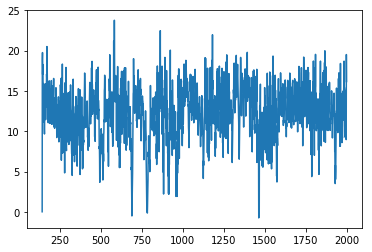

In [17]:
plt.plot(running_speed[:2000])

In [29]:
all_exps_df.to_hdf('exps_w_RSA.h5','all_exps_df',mode='w')

/opt/conda/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['cre_line', 'donor_name', 'reporter_line', 'specimen_name', 'tags', 'targeted_structure', 'rsa_mean_mean_mahala', 'rsa_random_mean_mahala', 'rsa_mean_mean_spectral_embedding', 'rsa_mean_mean_PCA', 'valid_stim']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [22]:
all_exps_df.loc[77,'rsa_mean_mean_mahala'].shape

(241, 241)

In [17]:
test_load= pd.read_hdf('exps_w_RSA.h5')

In [18]:
test_load

,cre_line,donor_name,failed,id,imaging_depth,reporter_line,specimen_name,tags,targeted_structure,rsa_mean_mean_mahala,rsa_random_mean_mahala,rsa_mean_mean_spectral_embedding,rsa_mean_mean_PCA
0,Cux2-CreERT2,283284,False,566759225,275,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-283284,[],VISam,"[[0.0, 15.0717277058, 11.2159497239, 12.801501...","[[0.0, 15.0717277058, 11.2159497239, 12.801501...",0,"[[0.0, 23.0786825252, 21.2174191481, 22.739709..."
1,Nr5a1-Cre,261969,False,546328009,350,Ai93(TITL-GCaMP6f),Nr5a1-Cre;Camk2a-tTA;Ai93-261969,[],VISal,"[[0.0, 0.741935932081, 0.599953696213, 0.80095...","[[0.0, 0.741935932081, 0.599953696213, 0.80095...",0,"[[0.0, 7.53542946705, 3.31196403877, 9.4400437..."
2,Scnn1a-Tg3-Cre,230570,False,511510911,350,Ai93(TITL-GCaMP6f),Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-230570,[],VISp,"[[0.0, 9.96030325168, 10.2589451811, 8.3752674...","[[0.0, 9.96030325168, 10.2589451811, 8.3752674...",0,"[[0.0, 24.1404450884, 30.7306092291, 21.571387..."
3,Emx1-IRES-Cre,284669,False,569792815,375,Ai93(TITL-GCaMP6f),Emx1-IRES-Cre;Camk2a-tTA;Ai93-284669,[],VISam,"[[0.0, 3.49558131281, 2.87681318643, 2.5342243...","[[0.0, 3.49558131281, 2.87681318643, 2.5342243...",0,"[[0.0, 8.53032612269, 9.03611995897, 6.9925695..."
4,Rbp4-Cre_KL100,234584,False,511511015,375,Ai93(TITL-GCaMP6f),Rbp4-Cre;Camk2a-tTA;Ai93-234584,[],VISpm,"[[0.0, 3.58087458183, 2.79741660163, 3.4468557...","[[0.0, 3.58087458183, 2.79741660163, 3.4468557...",0,"[[0.0, 26.8089158925, 21.1489539612, 25.902355..."
5,Rorb-IRES2-Cre,249122,False,530739574,275,Ai93(TITL-GCaMP6f),Rorb-IRES2-Cre;Camk2a-tTA;Ai93-249122,[],VISp,"[[0.0, 16.9749981708, 11.1635588031, 5.7946645...","[[0.0, 16.9749981708, 11.1635588031, 5.7946645...",0,"[[0.0, 45.4264556188, 37.5786379649, 22.869295..."
6,Cux2-CreERT2,222426,False,511510736,175,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-222426,[],VISp,"[[0.0, 14.507777463, 12.8903040028, 12.0233274...","[[0.0, 14.507777463, 12.8903040028, 12.0233274...",0,"[[0.0, 37.0929169706, 40.9273500961, 25.908877..."
7,Rorb-IRES2-Cre,222181,False,511510733,275,Ai93(TITL-GCaMP6f),Rorb-IRES2-Cre;Camk2a-tTA;Ai93-222181,[],VISpm,"[[0.0, 5.27233362171, 9.04609785123, 7.6294731...","[[0.0, 5.27233362171, 9.04609785123, 7.6294731...",0,"[[0.0, 19.2538742843, 24.8326007708, 24.153990..."
8,Cux2-CreERT2,225036,False,511510797,175,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-225036,[],VISal,"[[0.0, 28.8730031021, 29.2838277821, 21.066740...","[[0.0, 28.8730031021, 29.2838277821, 21.066740...",0,"[[0.0, 54.2795623211, 61.8146125533, 51.292421..."
9,Rorb-IRES2-Cre,228786,False,511511001,275,Ai93(TITL-GCaMP6f),Rorb-IRES2-Cre;Camk2a-tTA;Ai93-228786,[],VISpm,"[[0.0, 4.5980390289, 4.05711065567, 3.85395674...","[[0.0, 4.5980390289, 4.05711065567, 3.85395674...",0,"[[0.0, 22.4461604151, 20.3786944357, 22.028018..."
